In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import pandas as pd
import torch.optim as optim
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.data import DataLoader
import random
import warnings
import copy
import json  # Для сохранения гиперпараметров

warnings.filterwarnings("ignore")

In [15]:
class GNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32, hidden_num=2, conv_type='GCNConv',
                 activation='relu', pooling='global_mean_pool', task='node'):
        super(GNN, self).__init__()
        self.convs = nn.ModuleList()
        self.sm = nn.LogSoftmax(dim=1)
        self.convs.append(getattr(pyg_nn, conv_type)(input_dim, hidden_dim))
        for _ in range(hidden_num - 1):
            self.convs.append(getattr(pyg_nn, conv_type)(hidden_dim, hidden_dim))
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.activation = getattr(F, activation)
        self.pooling = pooling
        self.task = task

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.activation(x)

        if self.task == 'graph':
            # Убедимся, что применяется пуллинг, по умолчанию используем global_mean_pool
            pooling_fn = getattr(pyg_nn, self.pooling) if self.pooling else pyg_nn.global_mean_pool
            x = pooling_fn(x, batch)  # Агрегируем по графам
        elif self.task == 'node':
            pass  # Пуллинг не требуется для задачи классификации узлов

        x = self.linear(x)
        x = self.sm(x)  # Применяем логарифм софтмакса
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [16]:
def get_acc(loader, model, task, device, is_validation=False):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            pred_labels = pred.argmax(dim=1)
            label = data.y.to(device)

            if task == 'node':
                mask = data.val_mask if is_validation else data.test_mask
                pred_labels = pred_labels[mask]
                label = label[mask]

            if pred_labels.size(0) != label.size(0):
                print(f"Warning: Mismatched sizes in get_acc: pred.size(0)={pred_labels.size(0)}, label.size(0)={label.size(0)}")
                continue

            correct += pred_labels.eq(label).sum().item()
            total += pred_labels.size(0)

    total_acc = correct / total if total > 0 else 0
    return total_acc

In [17]:
def get_loss(loader, model, task, device, is_validation=True):
    total_loss = 0
    model.eval()

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            label = data.y.to(device)

            if task == 'node':
                mask = data.train_mask if is_validation else data.test_mask
                pred = pred[mask]
                label = label[mask]

            if pred.size(0) != label.size(0):
                print(f"Warning: Mismatched sizes in get_loss: pred.size(0)={pred.size(0)}, label.size(0)={label.size(0)}")
                continue

            loss = model.loss(pred, label)
            total_loss += loss.item() * data.num_graphs

    average_loss = total_loss / len(loader.dataset)
    return average_loss

In [18]:

def trainGNN(dataset, task, hidden_num, hidden_dim, conv_type, activation, pooling, lr=0.01,
            patience=10, max_epochs=200):
    """
    Обучение модели GNN с ранней остановкой.

    :param dataset: Датасет для обучения.
    :param task: Задача - 'node' или 'graph' классификация.
    :param hidden_num: Количество скрытых слоёв.
    :param hidden_dim: Размерность скрытых слоёв.
    :param conv_type: Тип свёрточного слоя.
    :param activation: Функция активации.
    :param pooling: Метод пуллинга.
    :param lr: Скорость обучения.
    :param patience: Число эпох без улучшения для ранней остановки.
    :param max_epochs: Максимальное число эпох обучения.
    :return: Обученная модель и её лучшая точность на валидации.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = GNN(max(dataset.num_node_features, 1), dataset.num_classes,
                hidden_num=hidden_num,
                hidden_dim=hidden_dim,
                conv_type=conv_type,
                activation=activation,
                pooling=pooling,
                task=task).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Разделение датасета
    if task == 'graph':
        data_size = len(dataset)
        train_dataset = dataset[:int(data_size * 0.6)]
        val_dataset = dataset[int(data_size * 0.6):int(data_size * 0.8)]
        test_dataset = dataset[int(data_size * 0.8):]
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    else:
        train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(dataset, batch_size=64, shuffle=False)
        test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    best_val_acc = 0.0
    best_model_state = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0
    previous_val_acc = 0.0


    for epoch in range(max_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.y.to(device)

            if task == 'node':
                mask = batch.train_mask
                pred = pred[mask]
                label = label[mask]

            if pred.size(0) != label.size(0):
                print(f"Warning: Mismatched sizes in training: pred.size(0)={pred.size(0)}, label.size(0)={label.size(0)}")
                continue

            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        average_train_loss = total_loss / len(train_loader.dataset)

        # Валидация
        val_loss = get_loss(val_loader, model, task, device, is_validation=True)
        val_acc = get_acc(val_loader, model, task, device, is_validation=True)

        print(f"Epoch {epoch + 1}/{max_epochs}, "
              f"Training Loss: {average_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_acc:.4f}")

        # Проверка на улучшение
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        elif val_acc == previous_val_acc:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        else:
            epochs_without_improvement = 0

        previous_val_acc = val_acc

    # Загрузка лучшей модели
    model.load_state_dict(best_model_state)

    # Оценка на тестовом наборе
    test_acc = get_acc(test_loader, model, task, device, is_validation=False)
    print(f"Test Accuracy: {test_acc:.4f}")

    return model, best_val_acc

In [19]:
class Individual:
    def __init__(self, hidden_num, hidden_dim, conv_type, activation, pooling, lr):
        self.hidden_num = hidden_num
        self.hidden_dim = hidden_dim
        self.conv_type = conv_type
        self.activation = activation
        self.pooling = pooling
        self.lr = lr
        self.fitness = 0.0  # Инициализация фитнеса

        # Сохранение гиперпараметров для анализа
        self.hyperparameters = {
            'hidden_num': self.hidden_num,
            'hidden_dim': self.hidden_dim,
            'conv_type': self.conv_type,
            'activation': self.activation,
            'pooling': self.pooling,
            'lr': self.lr,
            'fitness': self.fitness
        }

    def evaluate(self, dataset, task, patience=10, max_epochs=200):
        """
        Оценка индивида путём обучения GNN и получения точности на валидации.

        :param dataset: Датасет для обучения.
        :param task: Задача - 'node' или 'graph' классификация.
        :param patience: Параметр ранней остановки.
        :param max_epochs: Максимальное количество эпох обучения.
        """
        _, best_val_acc = trainGNN(dataset, task,
                                   hidden_num=self.hidden_num,
                                   hidden_dim=self.hidden_dim,
                                   conv_type=self.conv_type,
                                   activation=self.activation,
                                   pooling=self.pooling,
                                   lr=self.lr,
                                   patience=patience,
                                   max_epochs=max_epochs)
        self.fitness = best_val_acc  # Фитнес на основе точности на валидации

        # Обновление гиперпараметров
        self.hyperparameters['fitness'] = self.fitness


In [20]:
def initialize_population(pop_size, task):
    population = []
    for _ in range(pop_size):
        hidden_num = random.randint(2, 10)
        hidden_dim = random.randint(16, 128)
        conv_type = random.choice(['GCNConv', 'GraphConv', 'SAGEConv', 'GATConv'])
        activation = random.choice(['relu', 'tanh', 'sigmoid', 'silu'])
        if task == 'graph':
            pooling = random.choice(['global_mean_pool', 'global_max_pool'])  
        else:
            pooling = random.choice([None, 'global_mean_pool', 'global_max_pool'])
        lr = round(random.uniform(0.0001, 0.01), 4)
        individual = Individual(hidden_num, hidden_dim, conv_type, activation, pooling, lr)
        population.append(individual)
    return population

In [21]:
def selection(population, num_parents):
    #selected = random.sample(population, num_parents)
    #selected.sort(key=lambda x: x.fitness, reverse=True)
    #return selected[:num_parents]

    return sorted(population, key = lambda x: x.fitness, reverse=True)[:num_parents]

In [22]:
def crossover(parent1, parent2):
    hidden_num = random.choice([parent1.hidden_num, parent2.hidden_num])
    hidden_dim = random.choice([parent1.hidden_dim, parent2.hidden_dim])
    conv_type = random.choice([parent1.conv_type, parent2.conv_type])
    activation = random.choice([parent1.activation, parent2.activation])
    pooling = random.choice([parent1.pooling, parent2.pooling])
    lr = random.choice([parent1.lr, parent2.lr])
    return Individual(hidden_num, hidden_dim, conv_type, activation, pooling, lr)

In [23]:
def mutate(individual, mutation_rate, task):
    if random.random() < mutation_rate:
        individual.hidden_num = random.randint(2, 10)
    if random.random() < mutation_rate:
        individual.hidden_dim = random.randint(16, 128)
    if random.random() < mutation_rate:
        individual.conv_type = random.choice(['GCNConv', 'GraphConv', 'SAGEConv', 'GATConv'])
    if random.random() < mutation_rate:
        individual.activation = random.choice(['relu', 'tanh', 'sigmoid', 'silu'])
    if random.random() < mutation_rate:
        if task == 'graph':
            individual.pooling = random.choice(['global_mean_pool', 'global_max_pool'])  # Исключаем None
        else:
            individual.pooling = random.choice([None, 'global_mean_pool', 'global_max_pool'])
    if random.random() < mutation_rate:
        individual.lr = round(random.uniform(0.0001, 0.01), 4)
    return individual

In [24]:
def genetic_algorithm(dataset, task, pop_size=10, generations=10, mutation_rate=0.1,
                      patience=10, max_epochs=200, early_stop_generations=20):
    """
    Запуск генетического алгоритма для оптимизации архитектур GNN.

    :param dataset: Датасет для обучения.
    :param task: Задача - 'node' или 'graph' классификация.
    :param pop_size: Размер популяции.
    :param generations: Количество поколений.
    :param mutation_rate: Вероятность мутации.
    :param patience: Параметр ранней остановки для обучения отдельных индивидов.
    :param max_epochs: Максимальное количество эпох обучения для каждого индивида.
    :param early_stop_generations: Количество поколений без улучшения для остановки алгоритма.
    :return: Лучший найденный индивидуум.
    """
    population = initialize_population(pop_size, task)
    best_fitness_overall = 0.0
    best_individual_overall = None
    generations_without_improvement = 0

    # Для сохранения последних гиперпараметров
    last_individual = None

    for generation in range(generations):
        print(f"\n=== Поколение {generation + 1}/{generations} ===")
        for idx, individual in enumerate(population):
            print(f"\nОценка Индивида {idx + 1}/{len(population)}:")
            print(f"hidden_num={individual.hidden_num}, hidden_dim={individual.hidden_dim}, "
                  f"conv_type={individual.conv_type}, activation={individual.activation}, "
                  f"pooling={individual.pooling}, lr={individual.lr}")
            individual.evaluate(dataset, task, patience=patience, max_epochs=max_epochs)
            print(f"Фитнес (Точность на валидации): {individual.fitness:.4f}")

            # Сохранение последнего индивида
            last_individual = copy.deepcopy(individual)

            # Проверка на глобальное улучшение
            if individual.fitness > best_fitness_overall:
                best_fitness_overall = individual.fitness
                best_individual_overall = copy.deepcopy(individual)
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

        # Проверка условия ранней остановки для ГА
        if generations_without_improvement >= early_stop_generations:
            print(f"\nДостигнуто {generations_without_improvement} поколений без улучшения. Остановка ГА.")
            break

        # Селекция
        num_parents = max(2, pop_size // 2)  # Минимум два родителя
        parents = selection(population, num_parents)

        # Вывод лучшей фитнес в текущем поколении
        best_fitness = parents[0].fitness if parents else 0
        print(f"\nЛучшая фитнес в поколении {generation + 1}: {best_fitness:.4f}")

        # Кроссовер и мутация для создания новых потомков
        offspring = []
        while len(offspring) < pop_size - num_parents:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate, task)
            offspring.append(child)

        # Новая популяция состоит из родителей и потомков
        population = parents + offspring

    # Финальная сортировка и выбор лучшего индивида
    if not best_individual_overall:
        best_individual_overall = last_individual

    print("\n=== Генетический Алгоритм Завершён ===")
    print(f"Лучший Индивид: hidden_num={best_individual_overall.hidden_num}, "
          f"hidden_dim={best_individual_overall.hidden_dim}, conv_type={best_individual_overall.conv_type}, "
          f"activation={best_individual_overall.activation}, pooling={best_individual_overall.pooling}, "
          f"lr={best_individual_overall.lr}")
    print(f"Лучший Фитнес (Точность на валидации): {best_individual_overall.fitness:.4f}")

    # Сохранение лучших и последних гиперпараметров
    result = {
        'best_individual': best_individual_overall.hyperparameters,
        'last_individual': last_individual.hyperparameters if last_individual else {},
        'generations': generation + 1
    }

    # Сохранение в файл JSON
    with open(f'hyperparameters_results_{dataset_node}.json', 'w') as f:
        json.dump(result, f, indent=4)

    print("\nЛучшие и последние гиперпараметры сохранены в 'hyperparameters_results.json'.")

    return best_individual_overall

In [25]:
print("### Task: Graph Classification (PROTEINS Dataset) ###")
dataset_graph = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
# random.seed(42)
dataset_graph = dataset_graph.shuffle()
task_graph = 'graph'
best_individual_graph = genetic_algorithm(dataset_graph, task_graph,
                                              pop_size=10, generations=10, mutation_rate=0.1,
                                              patience=20, max_epochs=100, early_stop_generations=5)
print(f"\nBest architecture for graph task: hidden_num={best_individual_graph.hidden_num}, "
    f"hidden_dim={best_individual_graph.hidden_dim}, conv_type={best_individual_graph.conv_type}, "
    f"activation={best_individual_graph.activation}, pooling={best_individual_graph.pooling}, "
    f"lr={best_individual_graph.lr}")

### Task: Graph Classification (PROTEINS Dataset) ###

=== Поколение 1/10 ===

Оценка Индивида 1/10:
hidden_num=4, hidden_dim=25, conv_type=GraphConv, activation=silu, pooling=global_mean_pool, lr=0.0026
Epoch 1/100, Training Loss: 0.6683, Validation Loss: 0.6251, Validation Accuracy: 0.6278
Epoch 2/100, Training Loss: 0.6294, Validation Loss: 0.6586, Validation Accuracy: 0.6233
Epoch 3/100, Training Loss: 0.6333, Validation Loss: 0.6007, Validation Accuracy: 0.6951
Epoch 4/100, Training Loss: 0.6197, Validation Loss: 0.6062, Validation Accuracy: 0.7130
Epoch 5/100, Training Loss: 0.6113, Validation Loss: 0.6275, Validation Accuracy: 0.6502
Epoch 6/100, Training Loss: 0.6295, Validation Loss: 0.6194, Validation Accuracy: 0.6771
Epoch 7/100, Training Loss: 0.6066, Validation Loss: 0.6079, Validation Accuracy: 0.6906
Epoch 8/100, Training Loss: 0.6022, Validation Loss: 0.5964, Validation Accuracy: 0.6726
Epoch 9/100, Training Loss: 0.5975, Validation Loss: 0.5992, Validation Accuracy: 0.

In [26]:
print("### Task: Graph Classification (ENZYMES Dataset) ###")
dataset_graph = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
# random.seed(42)
dataset_graph = dataset_graph.shuffle()
task_graph = 'graph'
best_individual_graph = genetic_algorithm(dataset_graph, task_graph,
                                              pop_size=10, generations=10, mutation_rate=0.1,
                                              patience=20, max_epochs=100,early_stop_generations=5)
print(f"\nBest architecture for graph task: hidden_num={best_individual_graph.hidden_num}, "
    f"hidden_dim={best_individual_graph.hidden_dim}, conv_type={best_individual_graph.conv_type}, "
    f"activation={best_individual_graph.activation}, pooling={best_individual_graph.pooling}, "
    f"lr={best_individual_graph.lr}")

### Task: Graph Classification (ENZYMES Dataset) ###

=== Поколение 1/10 ===

Оценка Индивида 1/10:
hidden_num=8, hidden_dim=114, conv_type=GraphConv, activation=tanh, pooling=global_max_pool, lr=0.0059
Epoch 1/100, Training Loss: 1.9989, Validation Loss: 1.9853, Validation Accuracy: 0.1417
Epoch 2/100, Training Loss: 1.9064, Validation Loss: 1.8283, Validation Accuracy: 0.2083
Epoch 3/100, Training Loss: 1.8009, Validation Loss: 1.7988, Validation Accuracy: 0.2583
Epoch 4/100, Training Loss: 1.8002, Validation Loss: 1.8117, Validation Accuracy: 0.1750
Epoch 5/100, Training Loss: 1.8000, Validation Loss: 1.8012, Validation Accuracy: 0.2000
Epoch 6/100, Training Loss: 1.8134, Validation Loss: 1.7708, Validation Accuracy: 0.2083
Epoch 7/100, Training Loss: 1.7726, Validation Loss: 1.7542, Validation Accuracy: 0.2250
Epoch 8/100, Training Loss: 1.7565, Validation Loss: 1.7420, Validation Accuracy: 0.2500
Epoch 9/100, Training Loss: 1.7687, Validation Loss: 1.7202, Validation Accuracy: 0.2

In [27]:
import matplotlib.pyplot as plt

def plot_training_results(training_losses, validation_losses, training_accuracies, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(14, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss', color='blue')
    plt.plot(epochs, validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [29]:
ls


Untitled.ipynb                         kursach-Copy1.py
Untitled1.ipynb                        kursach.ipynb
Untitled2.ipynb                        myenv/
Untitled3.ipynb                        neironki3.ipynb
cora.xlsx                              nn2.ipynb
cora_individuals.xlsx                  nn2.py
data/                                  nn3.ipynb
enzymes.csv                            proteins.csv
graph_edit-Copy1.ipynb                 proteins_individuals.csv
graph_edit-Copy1.py                    proteins_training.txt
graph_edit.ipynb                       pubmed.csv
hyperparameters_results_cora().json    torch/
hyperparameters_results_pubmed().json  ~$cora.xlsx
kursach-Copy1.ipynb                    ~$cora_individuals.xlsx


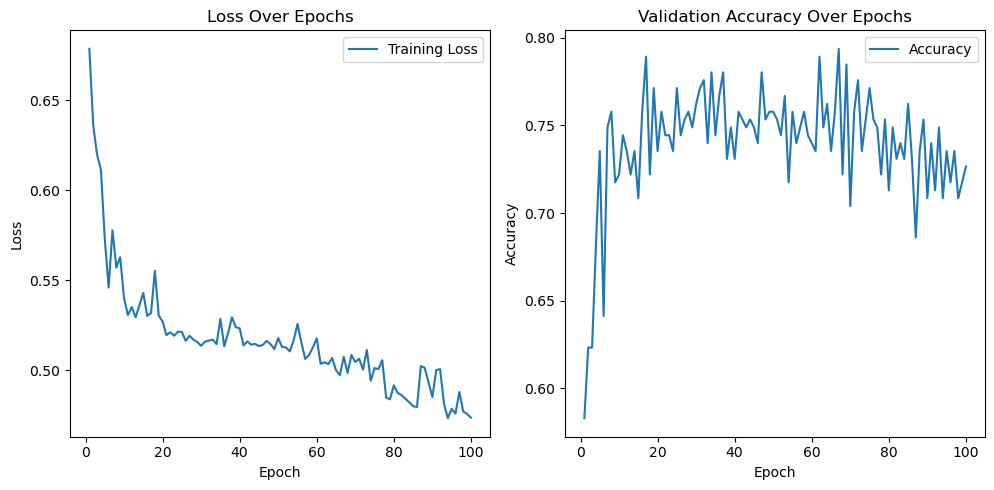

In [38]:
import re

def extract_data(log):
    epochs = []
    train_loss = []
    val_loss = []
    val_acc = []

    # Regular expressions to match the log lines
    epoch_pattern = re.compile(r'Epoch (\d+)/100')
    train_loss_pattern = re.compile(r'Training Loss: ([\d\.]+)')
    val_loss_pattern = re.compile(r'Validation Loss: ([\d\.]+)')
    val_acc_pattern = re.compile(r'Validation Accuracy: ([\d\.]+)')

    lines = log.split('\n')
    for line in lines:
        epoch_match = epoch_pattern.search(line)
        train_loss_match = train_loss_pattern.search(line)
        val_loss_match = val_loss_pattern.search(line)
        val_acc_match = val_acc_pattern.search(line)

        if epoch_match:
            epochs.append(int(epoch_match.group(1)))
        if train_loss_match:
            train_loss.append(float(train_loss_match.group(1)))
        if val_loss_match:
            val_loss.append(float(val_loss_match.group(1)))
        if val_acc_match:
            val_acc.append(float(val_acc_match.group(1)))

    return epochs, train_loss, val_loss, val_acc

# Example usage
log_data = """
Epoch 1/100, Training Loss: 0.6784, Validation Loss: 0.6648, Validation Accuracy: 0.5830
Epoch 2/100, Training Loss: 0.6361, Validation Loss: 0.6559, Validation Accuracy: 0.6233
Epoch 3/100, Training Loss: 0.6197, Validation Loss: 0.6311, Validation Accuracy: 0.6233
Epoch 4/100, Training Loss: 0.6114, Validation Loss: 0.6253, Validation Accuracy: 0.6816
Epoch 5/100, Training Loss: 0.5730, Validation Loss: 0.5912, Validation Accuracy: 0.7354
Epoch 6/100, Training Loss: 0.5460, Validation Loss: 0.6486, Validation Accuracy: 0.6413
Epoch 7/100, Training Loss: 0.5777, Validation Loss: 0.5741, Validation Accuracy: 0.7489
Epoch 8/100, Training Loss: 0.5571, Validation Loss: 0.5662, Validation Accuracy: 0.7578
Epoch 9/100, Training Loss: 0.5628, Validation Loss: 0.5930, Validation Accuracy: 0.7175
Epoch 10/100, Training Loss: 0.5400, Validation Loss: 0.5749, Validation Accuracy: 0.7220
Epoch 11/100, Training Loss: 0.5307, Validation Loss: 0.5444, Validation Accuracy: 0.7444
Epoch 12/100, Training Loss: 0.5352, Validation Loss: 0.5479, Validation Accuracy: 0.7354
Epoch 13/100, Training Loss: 0.5295, Validation Loss: 0.5771, Validation Accuracy: 0.7220
Epoch 14/100, Training Loss: 0.5362, Validation Loss: 0.5638, Validation Accuracy: 0.7354
Epoch 15/100, Training Loss: 0.5430, Validation Loss: 0.5836, Validation Accuracy: 0.7085
Epoch 16/100, Training Loss: 0.5303, Validation Loss: 0.5516, Validation Accuracy: 0.7578
Epoch 17/100, Training Loss: 0.5318, Validation Loss: 0.5406, Validation Accuracy: 0.7892
Epoch 18/100, Training Loss: 0.5553, Validation Loss: 0.5628, Validation Accuracy: 0.7220
Epoch 19/100, Training Loss: 0.5305, Validation Loss: 0.5524, Validation Accuracy: 0.7713
Epoch 20/100, Training Loss: 0.5271, Validation Loss: 0.5631, Validation Accuracy: 0.7354
Epoch 21/100, Training Loss: 0.5196, Validation Loss: 0.5359, Validation Accuracy: 0.7578
Epoch 22/100, Training Loss: 0.5212, Validation Loss: 0.5430, Validation Accuracy: 0.7444
Epoch 23/100, Training Loss: 0.5193, Validation Loss: 0.5465, Validation Accuracy: 0.7444
Epoch 24/100, Training Loss: 0.5215, Validation Loss: 0.5541, Validation Accuracy: 0.7354
Epoch 25/100, Training Loss: 0.5214, Validation Loss: 0.5391, Validation Accuracy: 0.7713
Epoch 26/100, Training Loss: 0.5164, Validation Loss: 0.5481, Validation Accuracy: 0.7444
Epoch 27/100, Training Loss: 0.5193, Validation Loss: 0.5360, Validation Accuracy: 0.7534
Epoch 28/100, Training Loss: 0.5171, Validation Loss: 0.5420, Validation Accuracy: 0.7578
Epoch 29/100, Training Loss: 0.5158, Validation Loss: 0.5381, Validation Accuracy: 0.7489
Epoch 30/100, Training Loss: 0.5137, Validation Loss: 0.5344, Validation Accuracy: 0.7623
Epoch 31/100, Training Loss: 0.5160, Validation Loss: 0.5301, Validation Accuracy: 0.7713
Epoch 32/100, Training Loss: 0.5165, Validation Loss: 0.5348, Validation Accuracy: 0.7758
Epoch 33/100, Training Loss: 0.5171, Validation Loss: 0.5499, Validation Accuracy: 0.7399
Epoch 34/100, Training Loss: 0.5146, Validation Loss: 0.5405, Validation Accuracy: 0.7803
Epoch 35/100, Training Loss: 0.5286, Validation Loss: 0.5433, Validation Accuracy: 0.7444
Epoch 36/100, Training Loss: 0.5134, Validation Loss: 0.5383, Validation Accuracy: 0.7668
Epoch 37/100, Training Loss: 0.5208, Validation Loss: 0.5293, Validation Accuracy: 0.7803
Epoch 38/100, Training Loss: 0.5295, Validation Loss: 0.5659, Validation Accuracy: 0.7309
Epoch 39/100, Training Loss: 0.5240, Validation Loss: 0.5588, Validation Accuracy: 0.7489
Epoch 40/100, Training Loss: 0.5234, Validation Loss: 0.5453, Validation Accuracy: 0.7309
Epoch 41/100, Training Loss: 0.5139, Validation Loss: 0.5281, Validation Accuracy: 0.7578
Epoch 42/100, Training Loss: 0.5161, Validation Loss: 0.5380, Validation Accuracy: 0.7534
Epoch 43/100, Training Loss: 0.5143, Validation Loss: 0.5374, Validation Accuracy: 0.7489
Epoch 44/100, Training Loss: 0.5148, Validation Loss: 0.5420, Validation Accuracy: 0.7534
Epoch 45/100, Training Loss: 0.5135, Validation Loss: 0.5371, Validation Accuracy: 0.7489
Epoch 46/100, Training Loss: 0.5142, Validation Loss: 0.5381, Validation Accuracy: 0.7399
Epoch 47/100, Training Loss: 0.5164, Validation Loss: 0.5337, Validation Accuracy: 0.7803
Epoch 48/100, Training Loss: 0.5146, Validation Loss: 0.5399, Validation Accuracy: 0.7534
Epoch 49/100, Training Loss: 0.5119, Validation Loss: 0.5439, Validation Accuracy: 0.7578
Epoch 50/100, Training Loss: 0.5180, Validation Loss: 0.5286, Validation Accuracy: 0.7578
Epoch 51/100, Training Loss: 0.5130, Validation Loss: 0.5350, Validation Accuracy: 0.7534
Epoch 52/100, Training Loss: 0.5128, Validation Loss: 0.5289, Validation Accuracy: 0.7444
Epoch 53/100, Training Loss: 0.5106, Validation Loss: 0.5332, Validation Accuracy: 0.7668
Epoch 54/100, Training Loss: 0.5167, Validation Loss: 0.5493, Validation Accuracy: 0.7175
Epoch 55/100, Training Loss: 0.5258, Validation Loss: 0.5241, Validation Accuracy: 0.7578
Epoch 56/100, Training Loss: 0.5156, Validation Loss: 0.5333, Validation Accuracy: 0.7399
Epoch 57/100, Training Loss: 0.5064, Validation Loss: 0.5317, Validation Accuracy: 0.7489
Epoch 58/100, Training Loss: 0.5086, Validation Loss: 0.5490, Validation Accuracy: 0.7578
Epoch 59/100, Training Loss: 0.5128, Validation Loss: 0.5398, Validation Accuracy: 0.7444
Epoch 60/100, Training Loss: 0.5178, Validation Loss: 0.5249, Validation Accuracy: 0.7399
Epoch 61/100, Training Loss: 0.5037, Validation Loss: 0.5288, Validation Accuracy: 0.7354
Epoch 62/100, Training Loss: 0.5045, Validation Loss: 0.5273, Validation Accuracy: 0.7892
Epoch 63/100, Training Loss: 0.5035, Validation Loss: 0.5141, Validation Accuracy: 0.7489
Epoch 64/100, Training Loss: 0.5069, Validation Loss: 0.5367, Validation Accuracy: 0.7623
Epoch 65/100, Training Loss: 0.5001, Validation Loss: 0.5234, Validation Accuracy: 0.7354
Epoch 66/100, Training Loss: 0.4974, Validation Loss: 0.5427, Validation Accuracy: 0.7578
Epoch 67/100, Training Loss: 0.5076, Validation Loss: 0.5218, Validation Accuracy: 0.7937
Epoch 68/100, Training Loss: 0.4986, Validation Loss: 0.5372, Validation Accuracy: 0.7220
Epoch 69/100, Training Loss: 0.5086, Validation Loss: 0.5189, Validation Accuracy: 0.7848
Epoch 70/100, Training Loss: 0.5047, Validation Loss: 0.5522, Validation Accuracy: 0.7040
Epoch 71/100, Training Loss: 0.5065, Validation Loss: 0.5159, Validation Accuracy: 0.7578
Epoch 72/100, Training Loss: 0.5005, Validation Loss: 0.5397, Validation Accuracy: 0.7758
Epoch 73/100, Training Loss: 0.5113, Validation Loss: 0.5318, Validation Accuracy: 0.7354
Epoch 74/100, Training Loss: 0.4943, Validation Loss: 0.5149, Validation Accuracy: 0.7534
Epoch 75/100, Training Loss: 0.5013, Validation Loss: 0.5315, Validation Accuracy: 0.7713
Epoch 76/100, Training Loss: 0.5008, Validation Loss: 0.5262, Validation Accuracy: 0.7534
Epoch 77/100, Training Loss: 0.5057, Validation Loss: 0.5309, Validation Accuracy: 0.7489
Epoch 78/100, Training Loss: 0.4850, Validation Loss: 0.5338, Validation Accuracy: 0.7220
Epoch 79/100, Training Loss: 0.4840, Validation Loss: 0.5159, Validation Accuracy: 0.7534
Epoch 80/100, Training Loss: 0.4917, Validation Loss: 0.5360, Validation Accuracy: 0.7130
Epoch 81/100, Training Loss: 0.4876, Validation Loss: 0.5261, Validation Accuracy: 0.7489
Epoch 82/100, Training Loss: 0.4863, Validation Loss: 0.5417, Validation Accuracy: 0.7309
Epoch 83/100, Training Loss: 0.4843, Validation Loss: 0.5271, Validation Accuracy: 0.7399
Epoch 84/100, Training Loss: 0.4823, Validation Loss: 0.5293, Validation Accuracy: 0.7309
Epoch 85/100, Training Loss: 0.4802, Validation Loss: 0.5457, Validation Accuracy: 0.7623
Epoch 86/100, Training Loss: 0.4797, Validation Loss: 0.5418, Validation Accuracy: 0.7309
Epoch 87/100, Training Loss: 0.5024, Validation Loss: 0.5670, Validation Accuracy: 0.6861
Epoch 88/100, Training Loss: 0.5015, Validation Loss: 0.5582, Validation Accuracy: 0.7354
Epoch 89/100, Training Loss: 0.4933, Validation Loss: 0.5560, Validation Accuracy: 0.7534
Epoch 90/100, Training Loss: 0.4852, Validation Loss: 0.5491, Validation Accuracy: 0.7085
Epoch 91/100, Training Loss: 0.5003, Validation Loss: 0.5442, Validation Accuracy: 0.7399
Epoch 92/100, Training Loss: 0.5007, Validation Loss: 0.5446, Validation Accuracy: 0.7130
Epoch 93/100, Training Loss: 0.4818, Validation Loss: 0.5640, Validation Accuracy: 0.7489
Epoch 94/100, Training Loss: 0.4735, Validation Loss: 0.5359, Validation Accuracy: 0.7085
Epoch 95/100, Training Loss: 0.4787, Validation Loss: 0.5396, Validation Accuracy: 0.7354
Epoch 96/100, Training Loss: 0.4761, Validation Loss: 0.5421, Validation Accuracy: 0.7175
Epoch 97/100, Training Loss: 0.4881, Validation Loss: 0.5441, Validation Accuracy: 0.7354
Epoch 98/100, Training Loss: 0.4773, Validation Loss: 0.5455, Validation Accuracy: 0.7085
Epoch 99/100, Training Loss: 0.4759, Validation Loss: 0.5377, Validation Accuracy: 0.7175
Epoch 100/100, Training Loss: 0.4738, Validation Loss: 0.5509, Validation Accuracy: 0.7265
"""

epochs, train_loss, val_loss, val_acc = extract_data(log_data)

# Plot the data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_acc, label='Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
ls

Untitled.ipynb                         kursach.ipynb
Untitled1.ipynb                        myenv/
Untitled2.ipynb                        neironki3.ipynb
Untitled3.ipynb                        nn2.ipynb
cora.xlsx                              nn2.py
cora_individuals.xlsx                  nn3.ipynb
data/                                  proteins.csv
df_pubmed_individuals.xlsx             proteins_individuals.csv
enzymes.csv                            proteins_training.txt
enzymes.txt                            pubmed.csv
graph_edit-Copy1.ipynb                 pubmed.xlsx
graph_edit-Copy1.py                    torch/
graph_edit.ipynb                       ~$cora.xlsx
hyperparameters_results_cora().json    ~$cora_individuals.xlsx
hyperparameters_results_pubmed().json  ~$df_pubmed_individuals.xlsx
kursach-Copy1.ipynb                    ~$pubmed.xlsx
kursach-Copy1.py


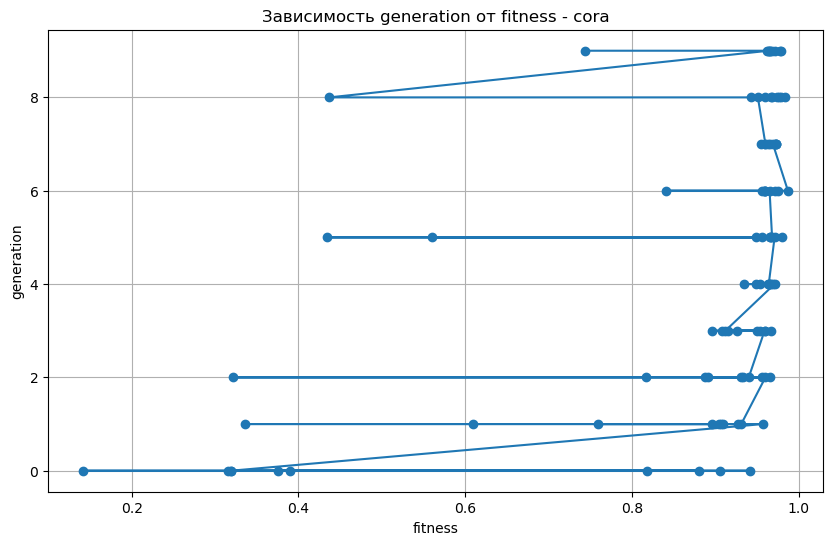

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Замените 'your_file.xlsx' на путь к вашему файлу Excel
file_path = 'cora_individuals.xlsx'

# Чтение данных из файла Excel
# Предположим, что данные находятся на первом листе
data = pd.read_excel(file_path)

# Предполагаем, что первая колонка это 'Column1', а вторая 'Column2'
# Замените 'Column1' и 'Column2' на реальные имена ваших колонок
x = data['fitness']
y = data['generation']

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')
plt.title('Зависимость generation от fitness - cora')
plt.xlabel('fitness')
plt.ylabel('generation')

plt.grid()
plt.show()

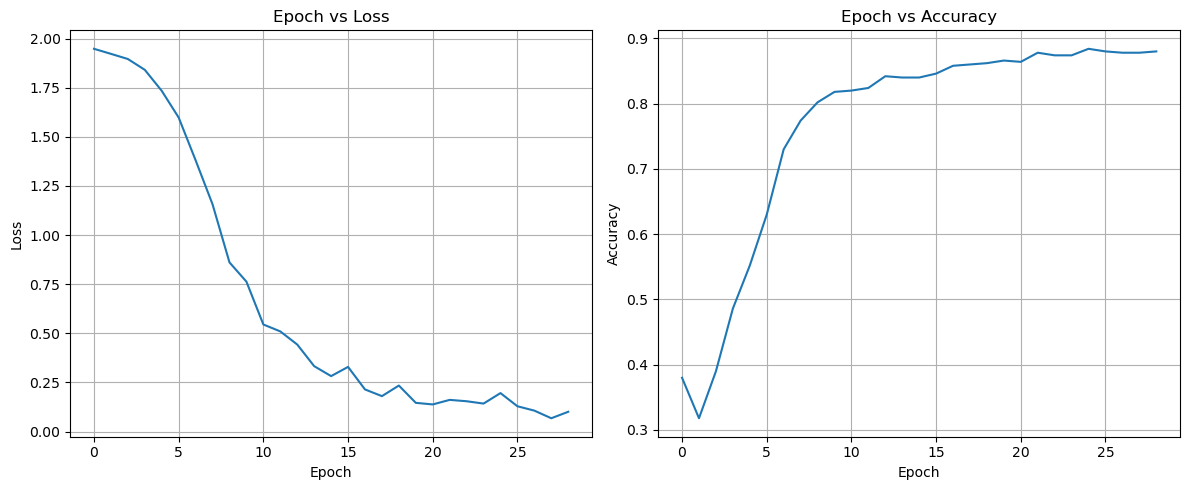

In [52]:
data = [
    [0, 1.948007584, 0.38, 1.938760042],
    [1, 1.922327518, 0.318, 1.910912395],
    [2, 1.896089196, 0.39, 1.871628046],
    [3, 1.8409729, 0.486, 1.795389891],
    [4, 1.734058619, 0.552, 1.671254635],
    [5, 1.598098993, 0.63, 1.510295153],
    [6, 1.380618095, 0.73, 1.310191631],
    [7, 1.156468987, 0.774, 1.123277068],
    [8, 0.860816002, 0.802, 0.952383876],
    [9, 0.762850463, 0.818, 0.870298862],
    [10, 0.544775546, 0.82, 0.841629267],
    [11, 0.509569883, 0.824, 0.777605355],
    [12, 0.442844927, 0.842, 0.696991384],
    [13, 0.332721442, 0.84, 0.599379122],
    [14, 0.282052428, 0.84, 0.559265256],
    [15, 0.328889817, 0.846, 0.515632868],
    [16, 0.214258432, 0.858, 0.488702387],
    [17, 0.180119112, 0.86, 0.445604026],
    [18, 0.234036684, 0.862, 0.458058387],
    [19, 0.146038771, 0.866, 0.413343102],
    [20, 0.137835905, 0.864, 0.367213488],
    [21, 0.161076948, 0.878, 0.370221198],
    [22, 0.154139757, 0.874, 0.348290861],
    [23, 0.142221212, 0.874, 0.331085443],
    [24, 0.195636883, 0.884, 0.306805164],
    [25, 0.128583029, 0.88, 0.313879371],
    [26, 0.106373064, 0.878, 0.296340197],
    [27, 0.067559853, 0.878, 0.291955411],
    [28, 0.100526921, 0.88, 0.268936962]
]

# Распаковка данных
x = [row[0] for row in data]
y1 = [row[1] for row in data]
y2 = [row[2] for row in data]
y3 = [row[3] for row in data]
# Создание графиков
plt.figure(figsize=(12, 5))

# Первый график: зависимость первой колонки от второй
plt.subplot(1, 2, 1)
plt.plot(x, y1)
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Второй график: зависимость первой колонки от третьей
plt.subplot(1, 2, 2)
plt.plot(x, y2)
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()